In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, classification_report, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.utils import plot_model

import utils
import datetime
import os
np.random.seed(42)

#  XGBoost

Defining constants

In [51]:
person = 'Davis'
#person = 'JOURNEY HOUSE TRAVEL INC'
cat_vars = ['Merchant Category Code (MCC)']
numeric_vars = ['Amount']
categories = ['Cardholder Last Name', 'Cardholder First Initial'] + numeric_vars + cat_vars
num_rounds = 15
params = {
    'max_depth':         12,
    'max_leaves':        2**12,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'tree_method':       'gpu_hist',
    'objective':         'binary:logistic',
}

In [52]:
df = utils.get_df()

In [53]:
transations = utils.get_person_balanced_df(df, person, categories, cat_vars, numeric_vars)
df_transations = transations[0][0]
labels = transations[1][0]

Training model

In [54]:
x_train, x_test, y_train, y_test = train_test_split(df_transations, labels, test_size=.25, random_state=42)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
evals = [(dtest, 'test'), (dtrain, 'train')]

In [55]:
model = xgb.train(params, dtrain, num_rounds, evals=evals)

[0]	test-logloss:0.68130	train-logloss:0.67663
[1]	test-logloss:0.67100	train-logloss:0.66245
[2]	test-logloss:0.66455	train-logloss:0.65195
[3]	test-logloss:0.65830	train-logloss:0.64261
[4]	test-logloss:0.65502	train-logloss:0.63589
[5]	test-logloss:0.64712	train-logloss:0.62489
[6]	test-logloss:0.64584	train-logloss:0.62041
[7]	test-logloss:0.64224	train-logloss:0.61160
[8]	test-logloss:0.64214	train-logloss:0.60863
[9]	test-logloss:0.63978	train-logloss:0.60054
[10]	test-logloss:0.63675	train-logloss:0.59362
[11]	test-logloss:0.63720	train-logloss:0.59180
[12]	test-logloss:0.63427	train-logloss:0.58640
[13]	test-logloss:0.63517	train-logloss:0.58519
[14]	test-logloss:0.63411	train-logloss:0.58096


Test Model

In [56]:
threshold = .5
true_labels = y_test.astype(int)
true_labels.sum()

277

In [57]:
preds = model.predict(dtest)
pred_labels = (preds > threshold).astype(int)

In [58]:
pred_labels.sum()

428

In [59]:
auc = roc_auc_score(true_labels, preds)
print('Auc:', auc)
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

Auc: 0.7219084284705662
Accuracy: 0.5821167883211679


Confusion Matrix :


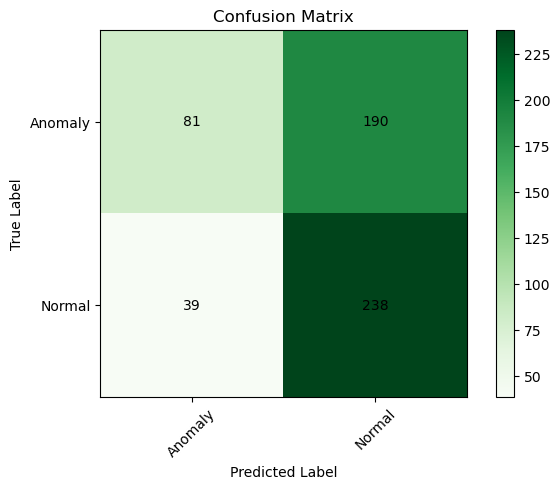

In [60]:
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

utils.plot_confusion_matrix(results, ['Anomaly','Normal'])

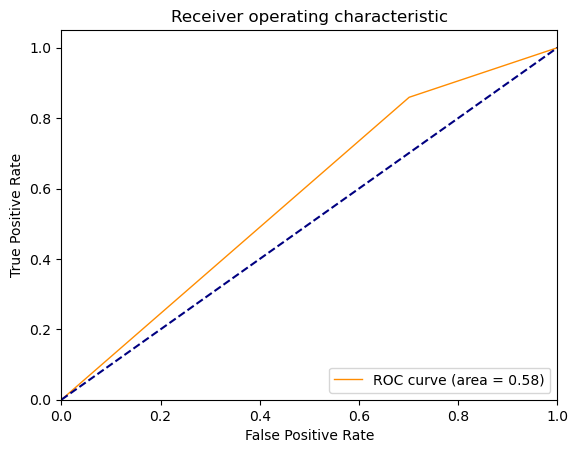

In [61]:
fpr, tpr, thresholds = roc_curve(true_labels, pred_labels)
roc_auc = roc_auc_score(true_labels, pred_labels)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

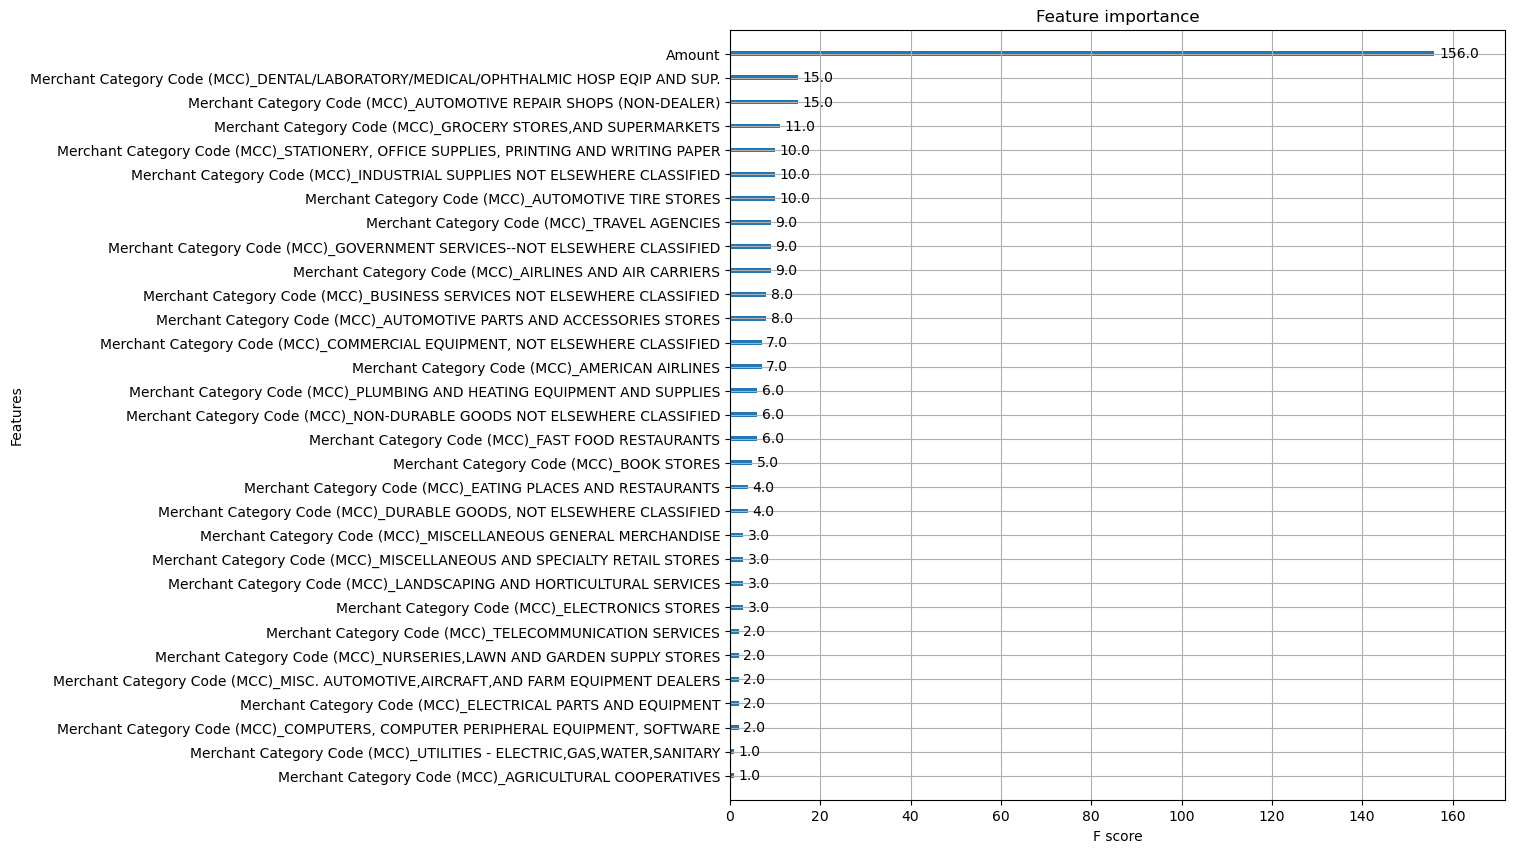

In [62]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 10)

# Tunning Hyperparams

In [ ]:
params = {
    'max_depth':         12,
    'max_leaves':        2**12,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'tree_method':       'gpu_hist',
    'objective':         'binary:logistic',
}

In [81]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 6, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'learning_rate': hp.uniform ('learning_rate', 0.01,0.2),
        'eta': hp.uniform ('eta', 0.01,0.2),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'n_estimators': 180,
        'seed': 0
    }

In [82]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], 
                    max_depth = int(space['max_depth']), 
                    gamma = space['gamma'],
                    learning_rate = space['learning_rate'],
                    reg_alpha = int(space['reg_alpha']),
                    eval_metric="auc",
                    early_stopping_rounds=10
                    )
    
    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    clf.fit(x_train, y_train, eval_set=evaluation, verbose=False)
    

    pred = clf.predict(x_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                 
0.49452554744525545                                    
SCORE:                                                                             
0.49452554744525545                                                                
SCORE:                                                                             
0.49452554744525545                                                                
SCORE:                                                                             
0.6313868613138686                                                                 
SCORE:                                                                             
0.49452554744525545                                                               
SCORE:                                                                            
0.49452554744525545                                                               
SCORE:                                             

In [83]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'eta': 0.012278091189361986, 'gamma': 1.3568923996867248, 'learning_rate': 0.1475148913215841, 'max_depth': 12.0, 'reg_alpha': 45.0, 'reg_lambda': 0.9242660043306147}


In [84]:
params = {
    'max_depth':         12,
    'reg_alpha':         45,
    'eta':               0.012,
    'gamma':             1.357,
    'learning_rate':     0.1475,
    'subsample':         1,
    'reg_lambda':        .92,
    'tree_method':       'gpu_hist',
    'objective':         'binary:logistic',
}

In [85]:
transations = utils.get_person_balanced_df(df, person, categories, cat_vars, numeric_vars)
df_transations = transations[0][0]
labels = transations[1][0]
x_train, x_test, y_train, y_test = train_test_split(df_transations, labels, test_size=.25, random_state=42)
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
evals = [(dtest, 'test'), (dtrain, 'train')]

In [86]:
model = xgb.train(params, dtrain, num_rounds, evals=evals)

[0]	test-logloss:0.68399	train-logloss:0.68105
[1]	test-logloss:0.67742	train-logloss:0.67164
[2]	test-logloss:0.67028	train-logloss:0.66399
[3]	test-logloss:0.66816	train-logloss:0.66221
[4]	test-logloss:0.66639	train-logloss:0.66074
[5]	test-logloss:0.66388	train-logloss:0.65733
[6]	test-logloss:0.66268	train-logloss:0.65635
[7]	test-logloss:0.66166	train-logloss:0.65553
[8]	test-logloss:0.66166	train-logloss:0.65553
[9]	test-logloss:0.66166	train-logloss:0.65553
[10]	test-logloss:0.66166	train-logloss:0.65553
[11]	test-logloss:0.66166	train-logloss:0.65553
[12]	test-logloss:0.66166	train-logloss:0.65553
[13]	test-logloss:0.66166	train-logloss:0.65553
[14]	test-logloss:0.66166	train-logloss:0.65553


In [87]:
transations_val_2 = utils.get_person_total_df(df, person, categories, cat_vars, numeric_vars)
df_transations_val_2 = transations_val_2[0][0]
labels_val_2 = transations_val_2[1][0]

In [88]:
dtest_val = xgb.DMatrix(df_transations_val_2, label=labels_val_2)

In [89]:
true_labels = y_test.astype(int)
preds_val = model.predict(dtest_val)
pred_labels_val = (preds_val > threshold).astype(int)

In [90]:
auc = roc_auc_score(true_labels, preds)
print('Auc:', auc)
print ('Accuracy:', accuracy_score(true_labels, pred_labels))

Auc: 0.7219084284705662
Accuracy: 0.5821167883211679


Confusion Matrix :


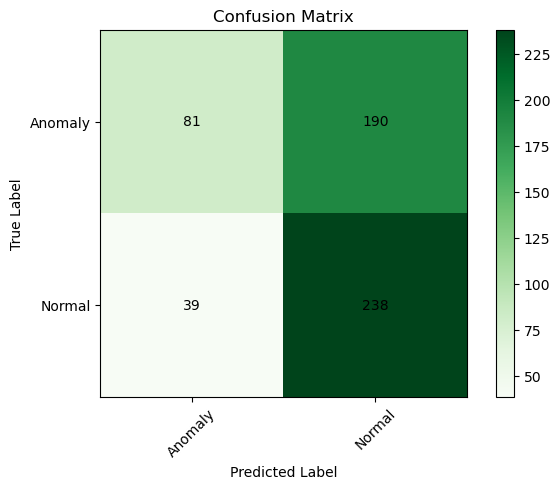

In [91]:
results = confusion_matrix(true_labels, pred_labels) 

print ('Confusion Matrix :')

utils.plot_confusion_matrix(results, ['Anomaly','Normal'])

# Test for all persons

In [92]:
def calc_accuracy(name: str):
    # Train Model
    transations = utils.get_person_balanced_df(df, name, categories, cat_vars, numeric_vars)
    df_transations = transations[0][0]
    labels = transations[1][0]
    x_train, x_test, y_train, y_test = train_test_split(df_transations, labels, test_size=.25, random_state=42)
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dtest = xgb.DMatrix(x_test, label=y_test)
    evals = [(dtest, 'test'), (dtrain, 'train')]
    model = xgb.train(params, dtrain, num_rounds, evals=evals)
    #Validation
    transations_val = utils.get_person_total_df(df, person, categories, cat_vars, numeric_vars)
    df_transations_val = transations_val[0][0]
    labels_val = transations_val[1][0]
    dtest_val = xgb.DMatrix(df_transations_val, label=labels_val)
    true_labels_val = labels_val.astype(int)
    preds_val = model.predict(dtest_val)
    pred_labels_val = (preds_val > threshold).astype(int)
    return accuracy_score(true_labels_val, pred_labels_val)

In [96]:
persons = list(df['Cardholder Last Name'].unique())
quantities = df['Cardholder Last Name'].value_counts()
values = []
names = []

for person in persons:
    if quantities[person] > 1000:
        accuracy = calc_accuracy(person)
        values.append(accuracy) 
        names.append(quantities[person])

[0]	test-logloss:0.68335	train-logloss:0.68006
[1]	test-logloss:0.67591	train-logloss:0.66981
[2]	test-logloss:0.67362	train-logloss:0.66709
[3]	test-logloss:0.67176	train-logloss:0.66486
[4]	test-logloss:0.66169	train-logloss:0.65419
[5]	test-logloss:0.65877	train-logloss:0.65039
[6]	test-logloss:0.65114	train-logloss:0.64216
[7]	test-logloss:0.64955	train-logloss:0.63997
[8]	test-logloss:0.64955	train-logloss:0.63997
[9]	test-logloss:0.64955	train-logloss:0.63997
[10]	test-logloss:0.64955	train-logloss:0.63997
[11]	test-logloss:0.64955	train-logloss:0.63997
[12]	test-logloss:0.64955	train-logloss:0.63997
[13]	test-logloss:0.64955	train-logloss:0.63997
[14]	test-logloss:0.64955	train-logloss:0.63997
[0]	test-logloss:0.68397	train-logloss:0.68106
[1]	test-logloss:0.67564	train-logloss:0.67170
[2]	test-logloss:0.67356	train-logloss:0.66968
[3]	test-logloss:0.67185	train-logloss:0.66803
[4]	test-logloss:0.67044	train-logloss:0.66667
[5]	test-logloss:0.66927	train-logloss:0.66554
[6]	test

Text(0, 0.5, 'Accuracy')

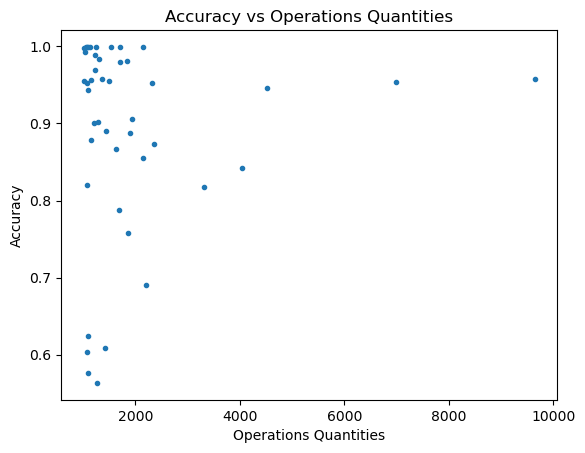

In [97]:
plt.figure()
plt.plot(names, values, ".")
plt.title("Accuracy vs Operations Quantities")
plt.xlabel("Operations Quantities")
plt.ylabel("Accuracy")